# Early Stopping

---

#### Goals

1. To understand the problem of overfitting
2. To know what countermeasures exist
3. To implement earlystopping
4. To compare earlystopping vs 

---

## 1. Library Importation & Device Preparation

In [34]:
# You don't need to edit this section today.
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from IPython.display import clear_output
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchsummary import summary as Summary
from torchvision.datasets import CIFAR10

from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   Resize

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## 2. Hyper-parameters

By executing below blocks, you can initialize/update hyper-parameters.

In [35]:
# Data Load
input_norm_mean = (.4914, .4822, .4465)
input_norm_std = (.2023, .1994, .2010)
batch_size = 2000

# Learning
logging_dispfig = True
#maximum_epoch = 500
earlystop_patience=40
learning_rate = 0.004

## 3. Data Load & Preprocessing

Today we will use CIFAR-10 dataset with data augmentation.

![CIFAR-10 examples](https://monet.postech.ac.kr/~wldh/CIFAR10.svg)

In [36]:
# Load dataset into python variable
input_transform = transforms.Compose([
  RandomCrop(32, padding=4),
  RandomHorizontalFlip(),
  ToTensor(),
  Normalize(mean=input_norm_mean, std=input_norm_std),
])

train_data = CIFAR10("./", train=True, transform=input_transform, download=True)
train_data, valid_data = random_split(train_data, [2000, 48000])
valid_data, trash_data = random_split(valid_data, [2000, 46000])
test_data = CIFAR10("./", train=False, transform=input_transform, download=False)

# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

Files already downloaded and verified


## 4. Function Definitions

Because our model is too simple now, we will use just `nn.Linear` module and wrap it with initializer function instead of defining a model class.

In [37]:
# Model
def init_model():
    global net, best_net, loss_fn, optim
    net = YetAnotherCNN().to(device)
    best_net = YetAnotherCNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
  
  
class YetAnotherCNN(nn.Module):
    """My Little Convolutional Neural Network for Active CAM, based on VGG11"""

    def __init__(self):
        super(YetAnotherCNN, self).__init__()
        self.convolution_part = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(0.1),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(0.1),
          nn.MaxPool2d(kernel_size=4, stride=3)
        )
        self.classifier_part = nn.Linear(32*5*5, 10, bias=False)

    def forward(self, data):
        conv_out = self.convolution_part(data)
        conv_out_flatten = conv_out.reshape(conv_out.size(0), -1)
        return self.classifier_part(conv_out_flatten)
        #return conv_out


# Model structure check
#Summary(YetAnotherCNN().to(device), (3, 32, 32), device=device)

In [38]:
# Epoch
def init_epoch():
    global epoch_cnt, earlystop_cnt
    epoch_cnt = 0
    earlystop_cnt=0


def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return earlystop_cnt < earlystop_patience

In [39]:
# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1
  
  
def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
#     if earlystop_cnt>0:
#         log_str += f' | es_cnt = {earlystop_cnt}'
    log_stack.append(log_str)

    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

    # Draw loss lines
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Draw accuracy lines
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
    acc_axis.set_ylabel('accuracy')

    # Append annotations
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
    loss_axis.grid()
    plt.title(f'Learning history until epoch {last(iter_log)}')
    plt.draw()
    
    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    if earlystop_cnt > 0:
        print(f'Current earlystop count = {earlystop_cnt} / {earlystop_patience}')

In [40]:
# Earlystopping Weight 카피
def copy_weights(src, dst):
    dst.load_state_dict(src.state_dict())

## 5. Training Iteration

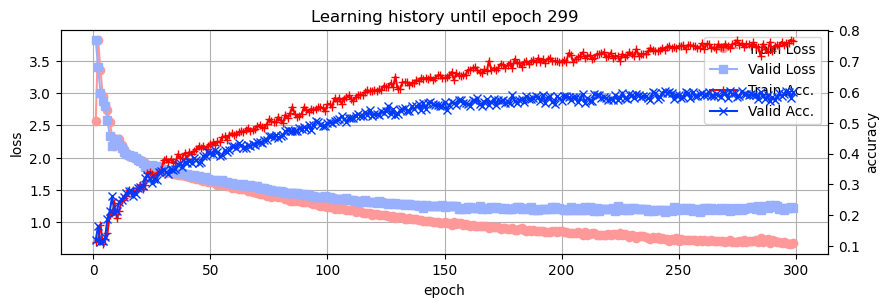

Current earlystop count = 40 / 40

 Training completed

Iter:  299 >> T_loss 0.67758    T_acc 0.76600   V_loss 1.21896    V_acc 0.59900   🕒 0.525s
Iter:  298 >> T_loss 0.66501    T_acc 0.76950   V_loss 1.24138    V_acc 0.58150   🕒 0.532s
Iter:  297 >> T_loss 0.66810    T_acc 0.76100   V_loss 1.21263    V_acc 0.59900   🕒 0.513s
Iter:  296 >> T_loss 0.67742    T_acc 0.75900   V_loss 1.21807    V_acc 0.60450   🕒 0.521s
Iter:  295 >> T_loss 0.68872    T_acc 0.75200   V_loss 1.18714    V_acc 0.59400   🕒 0.520s
Iter:  294 >> T_loss 0.67380    T_acc 0.76300   V_loss 1.22664    V_acc 0.58600   🕒 0.522s
Iter:  293 >> T_loss 0.68972    T_acc 0.75000   V_loss 1.20568    V_acc 0.59700   🕒 0.578s
Iter:  292 >> T_loss 0.69536    T_acc 0.75300   V_loss 1.25540    V_acc 0.58450   🕒 0.513s
Iter:  291 >> T_loss 0.70164    T_acc 0.75100   V_loss 1.27213    V_acc 0.57450   🕒 0.520s
Iter:  290 >> T_loss 0.71630    T_acc 0.73300   V_loss 1.23641    V_acc 0.58400   🕒 0.521s
Iter:  289 >> T_loss 0.67955    T_

In [41]:
# Training Initialization
init_model()
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        if len(vloss_log) and np.min(vloss_log) < vloss:
            earlystop_cnt += 1
        else :
            earlystop_cnt = 0
            copy_weights(net, best_net)
        record_valid_log(vloss, vacc)
    print_log()
    
copy_weights(best_net, net)    
    
print('\n Training completed\n')
for idx in reversed(range(len(log_stack))):
    print(log_stack[idx])

## 6. Result Analysis

In this section, we will calculate accuracy.

In [45]:
# Accuracy for test dataset
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader)
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

Test accuracy = 0.5960999727249146
Test loss = 1.1844885349273682


## 7. Saving Model

Are you satisfied with your model? Then save it!

In [43]:
torch.save(net, './model_stopping.pkl')

If you want to load your model, enter below.

In [44]:
net = torch.load('./model_stopping.pkl')